In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

df = pd.read_csv("cols_exist.csv")  
geometry = [Point(xy) for xy in zip(df['longitude']/1e6,df['latitude']/1e6)]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

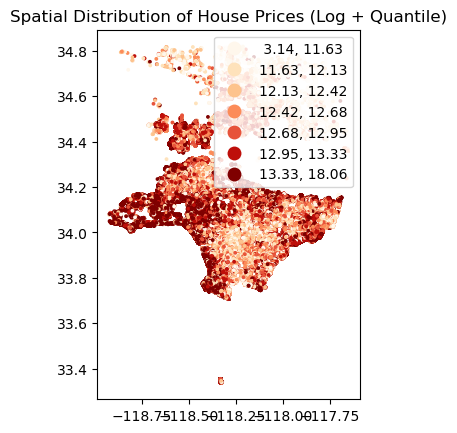

In [6]:
import matplotlib.pyplot as plt
import numpy as np
gdf["log_price"] = np.log(gdf["taxvaluedollarcnt"])
gdf.plot(
    column="log_price",
    cmap="OrRd",
    scheme="Quantiles",
    k=7,
    markersize=3,
    legend=True
)

plt.title("Spatial Distribution of House Prices (Log + Quantile)")
plt.show()

In [9]:
import esda
import libpysal
from libpysal.weights import KNN

w = KNN.from_dataframe(gdf, k=12)
w.transform = 'r'
y = gdf['taxvaluedollarcnt'].values
moran = esda.Moran(y, w)
print("Moran's I:", moran.I)
print("p-value:", moran.p_sim)

C:\Users\caiyu\anaconda3_2024_10_1\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2799 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: 0.4773458215711769
p-value: 0.001


## Local Moran’s I (LISA)

C:\Users\caiyu\anaconda3_2024_10_1\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


<Axes: >

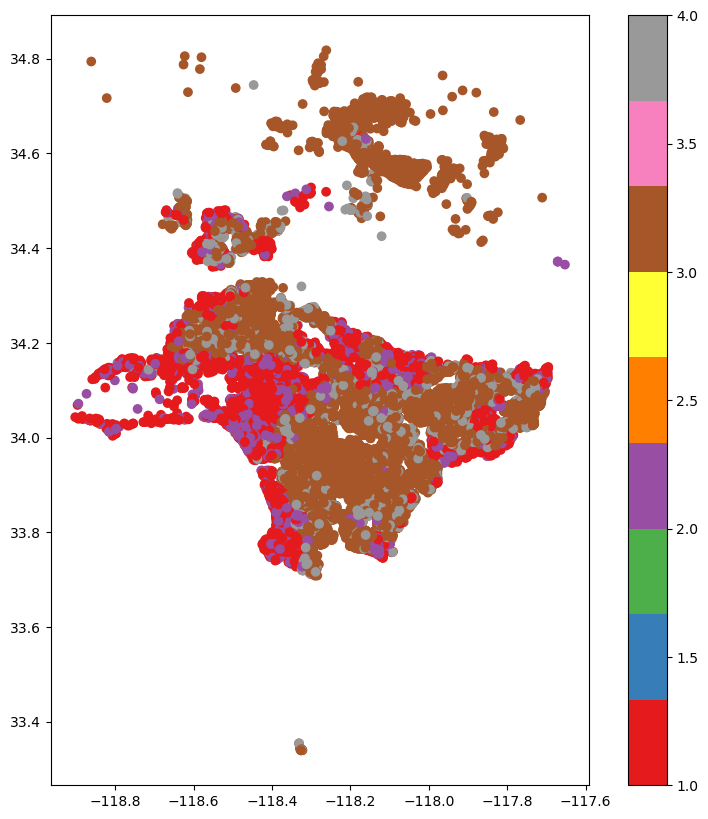

In [13]:
import random
import geopandas as gpd
import esda
from libpysal.weights import KNN

gdf_sample = gdf.sample(30000, random_state=42)
w = KNN.from_dataframe(gdf_sample, k=20)
w.transform = 'r'
y = gdf_sample['taxvaluedollarcnt'].values
lisa = esda.Moran_Local(y, w)
gdf_sample['LISA_cluster'] = lisa.q
gdf_sample.plot(column='LISA_cluster', cmap='Set1', legend=True, figsize=(10,10))

## Getis-Ord Gi*

In [14]:
from esda.getisord import G_Local

gdf_sample = gdf.sample(30000, random_state=42).reset_index(drop=True)

from libpysal.weights import KNN
w = KNN.from_dataframe(gdf_sample, k=10)
w.transform = 'r'
y = gdf_sample["taxvaluedollarcnt"].values

from esda.getisord import G_Local
gi = G_Local(y, w, permutations=0)
gdf_sample["GiZ"] = gi.Zs
gdf_sample["GiP"] = gi.p_norm

C:\Users\caiyu\anaconda3_2024_10_1\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


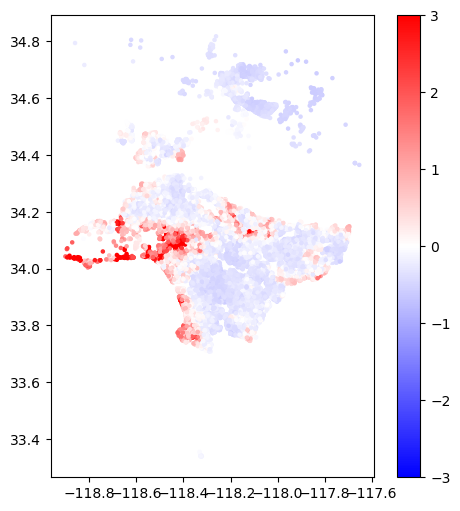

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
gdf_sample.plot(
    ax=ax,
    column="GiZ",
    cmap="bwr",
    vmin=-3,
    vmax=3,
    markersize=5
)
plt.colorbar(ax.collections[0], ax=ax)
plt.show()

In [16]:
gdf['log_sqft'] = np.log1p(gdf['finishedsquarefeet12'])
gdf['log_lot'] = np.log1p(gdf['lotsizesquarefeet'])
gdf['log_ratio'] = np.log1p(gdf['ratio'])

In [17]:
gdf['log_price'] = np.log1p(gdf['taxvaluedollarcnt'])
y = gdf['log_price'].values.reshape((-1,1))

In [18]:
X = gdf[['buildingqualitytypeid','yearbuilt','bathroomcnt','roomcnt',
         'unitcnt','log_sqft','log_lot','log_ratio']].values

In [19]:
from libpysal.weights import KNN
w = KNN.from_dataframe(gdf, k=8)
w.transform = 'r'

C:\Users\caiyu\anaconda3_2024_10_1\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4765 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


### OLS

In [20]:
from spreg import OLS
ols = OLS(y, X, name_y="log_price",
          name_x=['quality','year','bath','room','unit','log_sqft','log_lot','log_ratio'])
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:     1728046
Mean dependent var  :     12.5139                Number of Variables   :           9
S.D. dependent var  :      0.8442                Degrees of Freedom    :     1728037
R-squared           :      0.3093
Adjusted R-squared  :      0.3093
Sum squared residual:      850634                F-statistic           :  96747.6749
Sigma-square        :       0.492                Prob(F-statistic)     :           0
S.E. of regression  :       0.702                Log likelihood        :-1839601.738
Sigma-square ML     :       0.492                Akaike info criterion : 3679221.476
S.E of regression ML:      0.7016                Schwarz criterion     : 3679332.739

------------------------------------------------------------

### LM diagnostic test

In [21]:
from spreg.diagnostics_sp import LMtests

lm = LMtests(ols, w)

print("LM-Lag:", lm.lml)
print("Robust LM-Lag:", lm.rlml)
print("LM-Error:", lm.lme)
print("Robust LM-Error:", lm.rlme)
print("SARMA:", lm.sarma)

LM-Lag: (354232.1544890724, 0.0)
Robust LM-Lag: (36411.55158522883, 0.0)
LM-Error: (350895.1004358592, 0.0)
Robust LM-Error: (33074.497532015645, 0.0)
SARMA: (387306.652021088, 0.0)


In [22]:
from spreg import GM_Lag

sar = GM_Lag(y, X, w=w)
print(sar.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:     1728046
Mean dependent var  :     12.5139                Number of Variables   :          10
S.D. dependent var  :      0.8442                Degrees of Freedom    :     1728036
Pseudo R-squared    :      0.4074
Spatial Pseudo R-squared:  0.3239

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         4.99736         0.05891        84.83366         0.00000
               var_1        -0.01274         0.00032       -39.69767         0.00000
               var_2        -0.00074      